In [1]:
#!pip install torchviz==0.0.2 torchinfo==1.5.3 lightning-flash==0.5.2 

In [2]:
import os

In [3]:
os.environ["WANDB_DISABLED"] = "true"

In [4]:
import pandas as pd
import datetime
#import wandb
from matplotlib import pyplot as plt
import sklearn
import pytorch_lightning as pl
import flash
import flash.image
import os
import glob
import sklearn.model_selection
import numpy as np
import torch
import torchvision 
from torchvision import transforms as T
import flash.core.classification 
#import fiftyone as fo
import torchinfo
import torchviz
import matplotlib.image as mpimg
import itertools

In [5]:
#!pip install torchviz

In [6]:
pl.seed_everything(99)

Global seed set to 99


99

## Setup

download image data from http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz 

In [7]:
%%bash
if [ ! -d artifacts/data/ ] 
then
    mkdir -p artifacts/data/
    cd artifacts/data/
    wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz 
    tar -xvf food-101.tar.gz 
fi



# Explore Data

In [8]:
data_dir = "artifacts/data/food-101/"



In [9]:
!ls {data_dir}

images	license_agreement.txt  meta  README.txt


In [10]:
# read file that list of all images 
df = pd.read_csv(f"{data_dir}/meta/train.txt",header=None,names=['file_path'])

# extract label from the last suffix of file path
df['label_name'] = df['file_path'].apply(lambda x:x.split("/")[-2])

# createa column file path that is full path
df['file_path'] = data_dir + "images/"+ df["file_path"]+".jpg"



In [11]:
!head {data_dir}/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [12]:
df.head()

,file_path,label_name
0,artifacts/data/food-101/images/apple_pie/10056...,apple_pie
1,artifacts/data/food-101/images/apple_pie/10147...,apple_pie
2,artifacts/data/food-101/images/apple_pie/10263...,apple_pie
3,artifacts/data/food-101/images/apple_pie/10287...,apple_pie
4,artifacts/data/food-101/images/apple_pie/10432...,apple_pie


all the 101 classes that are in the dataset

In [13]:
df['label_name'].value_counts()

beet_salad              750
prime_rib               750
pulled_pork_sandwich    750
baklava                 750
beef_carpaccio          750
                       ... 
dumplings               750
bibimbap                750
pancakes                750
cup_cakes               750
baby_back_ribs          750
Name: label_name, Length: 101, dtype: int64

play with the below line to only work on a subset of the dataset

In [14]:
product_types = list (set(df['label_name']))

product_types = ["foie_gras","churros","hummus","hot_dog","crab_cakes"
                 ,"steak","escargots","pancakes","carrot_cake","beef_tartare"]

product_types = ["foie_gras","churros","hummus"]

In [15]:
# get data only in the subset
df = df [ df["label_name"].isin(product_types) ]

## Label Encoding
create a mapping from string to int for class labels

In [16]:
label_encoder = sklearn.preprocessing.LabelEncoder()


In [17]:
label_encoder.fit(df['label_name'])


LabelEncoder()

In [18]:
df['label'] = label_encoder.transform(df['label_name'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
df.head()

,file_path,label_name,label
17250,artifacts/data/food-101/images/churros/1004234...,churros,0
17251,artifacts/data/food-101/images/churros/1013460...,churros,0
17252,artifacts/data/food-101/images/churros/1016791...,churros,0
17253,artifacts/data/food-101/images/churros/102100.jpg,churros,0
17254,artifacts/data/food-101/images/churros/1025494...,churros,0


apply same process on the evaluation dataset

In [20]:
df_eval = pd.read_csv(f"{data_dir}/meta/test.txt",header=None,names=['file_path'])
df_eval['label_name'] = df_eval['file_path'].apply(lambda x:x.split("/")[-2])

df_eval = df_eval [ df_eval["label_name"].isin(product_types) ]

df_eval['file_path'] = f"{data_dir}/images/" + df_eval["file_path"]+".jpg"
df_eval['label'] = label_encoder.transform(df_eval['label_name'])

## Train Test Split

In [21]:
# split the dataset; 85% for training and 15 % for testing
df_train, df_test = sklearn.model_selection.train_test_split(df, test_size=0.15, stratify=df['label'],shuffle = True) 

# split the training dataset: 80% for actual training and 20% for validation
df_train, df_val = sklearn.model_selection.train_test_split(df_train, test_size=0.20, random_state=1 , stratify=df_train['label'])

In [22]:
print ({"train": len(df_train), "test":len(df_test), "val":len(df_val) ,"eval": len(df_eval)  })

{'train': 1529, 'test': 338, 'val': 383, 'eval': 750}


## Modelling

default transformations done on an image

In [23]:
default_transforms = flash.image.classification.transforms.default_transforms((224, 224))
default_transforms

{'collate': <function flash.core.data.transforms.kornia_collate>,
 'per_batch_transform_on_device': ApplyToKeys(keys=<DefaultDataKeys.INPUT: 'input'>, transform=Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), p=1.0, p_batch=1.0, same_on_batch=True, return_transform=False)),
 'post_tensor_transform': ApplyToKeys(keys=<DefaultDataKeys.INPUT: 'input'>, transform=Resize()),
 'to_tensor_transform': Sequential(
   (0): ApplyToKeys(keys=<DefaultDataKeys.INPUT: 'input'>, transform=FuncModule())
   (1): ApplyToKeys(keys=<DefaultDataKeys.TARGET: 'target'>, transform=FuncModule())
 )}

extra transformations to be done on an image while training

In [24]:
post_tensor_transform = flash.core.data.transforms.ApplyToKeys(
    flash.core.data.data_source.DefaultDataKeys.INPUT,
    T.Compose([
        T.RandomHorizontalFlip(), 
        T.ColorJitter(), 
        T.RandomAutocontrast(), 
        T.RandomPerspective()
    ]),
)

new_transforms = flash.core.data.transforms.merge_transforms(default_transforms, {"post_tensor_transform": post_tensor_transform})

In [25]:
# use gpu if available or choose cpu 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


create a pytorch ligthning module that can be used to be fed to model

In [26]:
datamodule = flash.image.ImageClassificationData.from_data_frame(
    "file_path",
    "label",
    train_data_frame=df_train,
    val_data_frame=df_val,
    test_data_frame=df_test,
    train_transform=new_transforms,
    batch_size=64,
    num_workers=16
)

/usr/local/lib/python3.7/dist-packages/flash/core/data/data_source.py:575: UserWarning: Using default resolver, this may take a while.
  warnings.warn("Using default resolver, this may take a while.", UserWarning)
Resolving files: 100%|██████████| 1529/1529 [00:02<00:00, 747.31it/s]
/usr/local/lib/python3.7/dist-packages/flash/core/data/data_source.py:575: UserWarning: Using default resolver, this may take a while.
  warnings.warn("Using default resolver, this may take a while.", UserWarning)
Resolving files: 100%|██████████| 383/383 [00:00<00:00, 793.90it/s]
/usr/local/lib/python3.7/dist-packages/flash/core/data/data_source.py:575: UserWarning: Using default resolver, this may take a while.
  warnings.warn("Using default resolver, this may take a while.", UserWarning)
Resolving files: 100%|██████████| 338/338 [00:00<00:00, 762.08it/s]


In [27]:
df_train.head().iloc[0].to_dict()

{'file_path': 'artifacts/data/food-101/images/hummus/917579.jpg',
 'label': 2,
 'label_name': 'hummus'}

In [28]:
datamodule

In [29]:
datamodule.num_classes


3

In [30]:
backbones = flash.image.ImageClassifier.available_backbones()
backbones



['adv_inception_v3',
 'bat_resnext26ts',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspdarknet53_iabn',
 'cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'cspresnext50',
 'cspresnext50_iabn',
 'darknet53',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet121d',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenet264',
 'densenet264d_iabn',
 'densenetblur121d',
 'dino_deits16',
 'dino_deits8',
 'dino_vitb16',
 'dino_vitb8',
 'dla102',
 

Look at avaialble models 
https://pytorch.org/vision/stable/models.html
    
 
ResNet, MobileNetV2, ResNeXt , EfficientNet 

In [31]:
!pip install lightning-flash==0.5.2  'lightning-flash[image]'==0.5.2

backbone model to use 

In [32]:
model_name = "resnet50"


In [33]:
model = flash.image.ImageClassifier(num_classes=datamodule.num_classes,backbone=model_name)
model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ImageClassifier(
  (train_metrics): ModuleDict(
    (accuracy): Accuracy()
  )
  (val_metrics): ModuleDict(
    (accuracy): Accuracy()
  )
  (test_metrics): ModuleDict(
    (accuracy): Accuracy()
  )
  (adapter): DefaultAdapter(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (c

In [34]:
#

### visualize model

In [35]:
sample_input_size = (1, 3, 224, 224)


model_summary = torchinfo.summary(model, input_size=sample_input_size, verbose=2)
model_summary

Layer (type:depth-idx)                             Output Shape              Param #
ImageClassifier                                    --                        --
├─DefaultAdapter: 1                                --                        --
│    └─ResNet: 2-1                                 [1, 2048]                 --
│    │    └─conv1.weight                                                     ├─9,408
│    │    └─bn1.weight                                                       ├─64
│    │    └─bn1.bias                                                         ├─64
│    │    └─layer1.0.conv1.weight                                            ├─4,096
│    │    └─layer1.0.bn1.weight                                              ├─64
│    │    └─layer1.0.bn1.bias                                                ├─64
│    │    └─layer1.0.conv2.weight                                            ├─36,864
│    │    └─layer1.0.bn2.weight                                              ├─64
│    │   

Layer (type:depth-idx)                             Output Shape              Param #
ImageClassifier                                    --                        --
├─DefaultAdapter: 1                                --                        --
│    └─ResNet: 2-1                                 [1, 2048]                 --
│    │    └─conv1.weight                                                     ├─9,408
│    │    └─bn1.weight                                                       ├─64
│    │    └─bn1.bias                                                         ├─64
│    │    └─layer1.0.conv1.weight                                            ├─4,096
│    │    └─layer1.0.bn1.weight                                              ├─64
│    │    └─layer1.0.bn1.bias                                                ├─64
│    │    └─layer1.0.conv2.weight                                            ├─36,864
│    │    └─layer1.0.bn2.weight                                              ├─64
│    │   

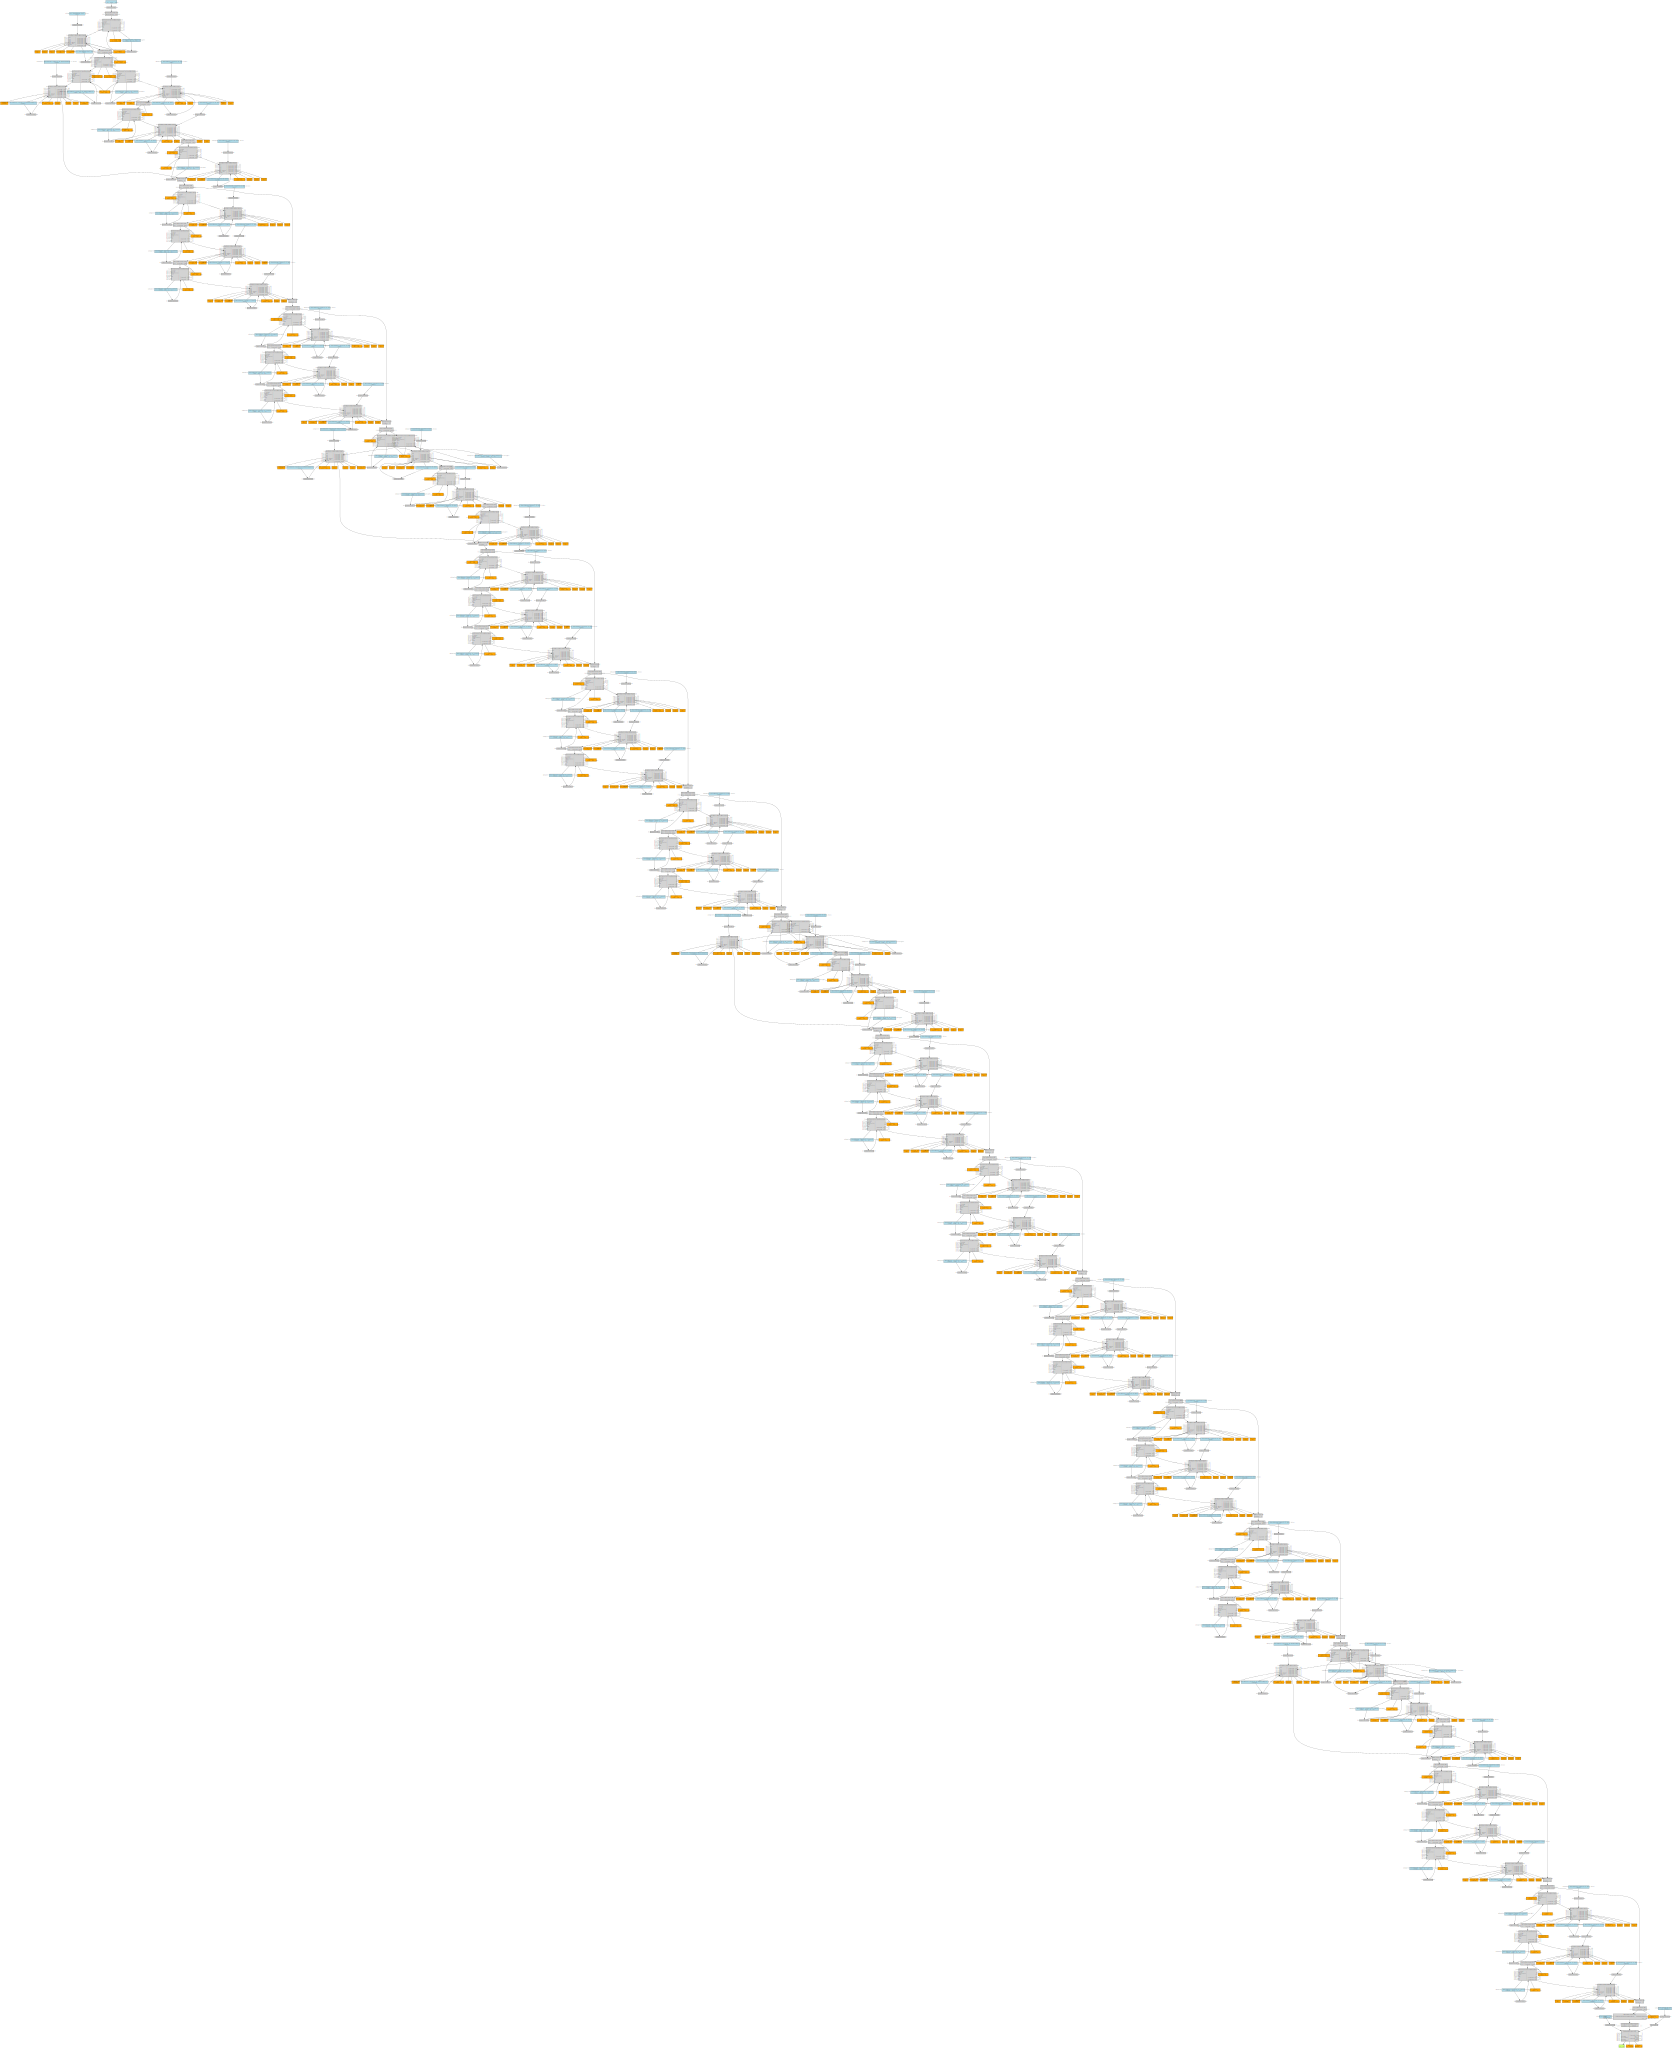

In [36]:
random_tensor = torch.randn(1, 3, 224, 224).requires_grad_(True).to(device)
output_tensor = model(random_tensor).to(device)

torchviz.make_dot(
    output_tensor
    , params=dict(model.named_parameters())
    , show_attrs=True
    , show_saved=True)

In [37]:
## Train model

In [38]:
epochs = 10
unfreeze_epoch = 5

In [39]:
trainer = flash.Trainer(max_epochs=epochs, gpus=torch.cuda.device_count() )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [40]:
trainer.finetune(model, datamodule=datamodule
                 , strategy=flash.core.finetuning.FreezeUnfreeze(unfreeze_epoch=unfreeze_epoch) )

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:91: LightningDeprecationWarning: Method `on_train_dataloader` is deprecated in v1.5.0 and will be removed in v1.7.0. Please use `train_dataloader()` directly.
  "Method `on_train_dataloader` is deprecated in v1.5.0 and will be removed in v1.7.0."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:126: LightningDeprecationWarning: Method `on_val_dataloader` is deprecated in v1.5.0 and will be removed in v1.7.0. Please use `val_dataloader()` directly.
  "Method `on_val_dataloader` is deprecated in v1.5.0 and will be removed in v1.7.0."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type           | Params
-------------------------------------------------
0 | train_metrics | ModuleDict     | 0     
1 | val_metrics   | ModuleDict     | 0     
2 | test_metrics  | ModuleDict     | 0     
3 | adapter       | DefaultAdapter | 23.5 M
--------------

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please spe

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for de

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for de

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for de

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/finetuning.py:212: UserWarning: The provided params to be frozen already exist within another group of this optimizer. Those parameters will be skipped.
HINT: Did you init your optimizer in `configure_optimizer` as such:
 <class 'torch.optim.adam.Adam'>(filter(lambda p: p.requires_grad, self.parameters()), ...) 
  UserWarning,


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [41]:
artifact_model_path = "artifacts/model/model.pt"

In [42]:
trainer.save_checkpoint(artifact_model_path)

In [43]:
## Load model

In [44]:
model = flash.image.ImageClassifier.load_from_checkpoint(artifact_model_path)
model.serializer = flash.core.classification.Probabilities()

#model.serializer = flash.core.classification.Logits()

In [45]:
!ls {data_dir}/images/foie_gras | head -n 2

1004944.jpg
1007306.jpg


In [46]:
sample_image_path = f"{data_dir}/images/churros/1004234.jpg"

#sample_image_path = f"{data_dir}/images/foie_gras/1004944.jpg"

sample_image_path = f"{data_dir}/images/foie_gras/1004944.jpg"


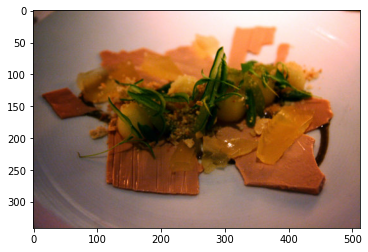

In [47]:
image = mpimg.imread(sample_image_path)
plt.imshow(image)

In [48]:
predictions = model.predict(sample_image_path)
predictions

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


[[1.1590245208026317e-07, 0.9999992847442627, 5.537629022001056e-07]]

In [49]:
sorted ( zip (label_encoder.classes_, predictions[0]), key= lambda x:x[1] ,reverse =True)

[('foie_gras', 0.9999992847442627),
 ('hummus', 5.537629022001056e-07),
 ('churros', 1.1590245208026317e-07)]

In [50]:
!ls -lah artifacts/model

total 270M
drwxr-xr-x 2 root root 4.0K Nov 19 22:26 .
drwxr-xr-x 4 root root 4.0K Nov 19 22:26 ..
-rw-r--r-- 1 root root 270M Nov 19 22:26 model.pt


In [51]:
?flash.image.ImageClassificationData.from_data_frame

In [52]:
datamodule_predict = flash.image.ImageClassificationData.from_data_frame(
    "file_path",
    "label",
    predict_data_frame=df_eval,
    batch_size=64,
    num_workers=16
)

/usr/local/lib/python3.7/dist-packages/flash/core/data/data_source.py:575: UserWarning: Using default resolver, this may take a while.
  warnings.warn("Using default resolver, this may take a while.", UserWarning)
Resolving files: 100%|██████████| 750/750 [00:01<00:00, 745.30it/s]


In [53]:
model.serializer = flash.core.classification.Probabilities()

predictions = trainer.predict(model,datamodule=datamodule_predict)
predictions = list(itertools.chain.from_iterable(predictions))  # flatten batches


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:174: LightningDeprecationWarning: Method `on_predict_dataloader` is deprecated in v1.5.0 and will be removed in v1.7.0. Please use `predict_dataloader()` directly.
  f"Method `{on_eval_hook}` is deprecated in v1.5.0 and will"
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicting: 23it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for de

In [54]:
y_proba = predictions
y_pred = np.argmax(y_proba, axis=1)
y_true = df_eval['label']

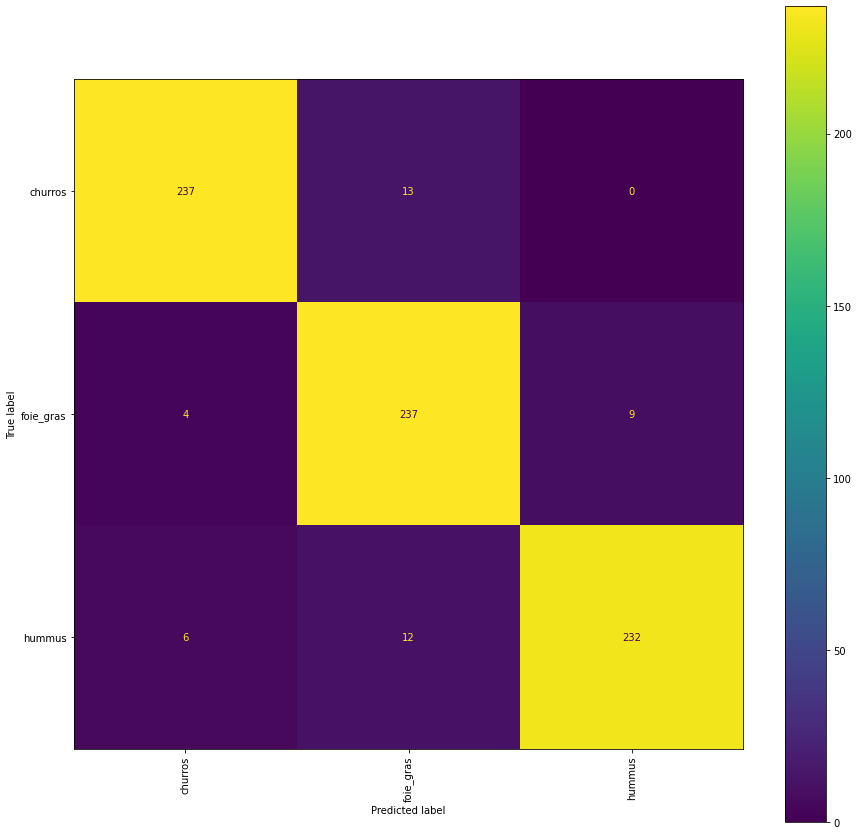

In [55]:
# https://stackoverflow.com/questions/60860121/plotly-how-to-make-an-annotated-confusion-matrix-using-a-heatmap
fig, ax = plt.subplots(figsize=(15,15))
cm_labels = label_encoder.classes_
disp = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
    y_true=y_true, y_pred = y_pred ,
    #normalize = 'true',
    display_labels=cm_labels,
    xticks_rotation='vertical',
    ax=ax
)
disp